<a href="https://colab.research.google.com/github/Prasad-Khedkar/Topic_Modelling_on_News_Articles/blob/main/Topic_Modelling_on_News_Articles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
path = '/content/drive/My Drive/Projects/Topic_Modelling_on_News_Articles/Data/bbc/'

In [4]:
news = []   ## Empty list for storing actual news in text       
topics = [] ## Empty list for new theme

In [5]:
Themes = ['business','entertainment','politics','sport','tech']  ## News themes 

In [6]:
for x in Themes:                               ## For every item in Themes
    all_txt_files=os.listdir(path+x)           ## List al files present in given path
    for files in all_txt_files:                ## For every item in txt_files
        txt_path=path + x + '/' + files        ## specifying exact path of every text news file
        with open(txt_path,'rb') as f:         ## open a text file
            text=f.read()                      ## read text file
        news.append(text)                      ## append text file which is our news, to empty news list
        topics.append(x)                       ## append the topic of news file to empty topics list

In [7]:
df_raw = pd.DataFrame()              ## creating empty dataframe

In [8]:
df_raw['News'] = news                ## adding News column 
df_raw['News_Theme'] = topics        ## adding News_theme column

In [9]:
df_raw.head()

,News,News_Theme
0,b'Dollar gains on Greenspan speech\n\nThe doll...,business
1,"b'India calls for fair trade rules\n\nIndia, w...",business
2,b'Ethiopia\'s crop production up 24%\n\nEthiop...,business
3,b'Japan narrowly escapes recession\n\nJapan\'s...,business
4,"b'Steel firm \'to cut\' 45,000 jobs\n\nMittal ...",business


In [10]:
df_raw.tail()

,News,News_Theme
2220,b'Court mulls file-sharing future\n\nJudges at...,tech
2221,b'\'Podcasters\' look to net money\n\nNasa is ...,tech
2222,b'Hitachi unveils \'fastest robot\'\n\nJapanes...,tech
2223,b'Sony PSP tipped as a \'must-have\'\n\nSony\'...,tech
2224,b'Spam e-mails tempt net shoppers\n\nComputer ...,tech


In [11]:
df_raw.shape            ## Shape of raw data with total 2225 rows and 2 columns

(2225, 2)

## Data Cleaning

In [12]:
df = df_raw.copy()      ## First creating a deep copy

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   News        2225 non-null   object
 1   News_Theme  2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [14]:
df.isnull().sum()

News          0
News_Theme    0
dtype: int64

### *Insight* : No null values present 

In [15]:
df.drop_duplicates(keep = 'first',inplace = True)  ## Dropping duplicate values/rows

In [16]:
df.shape        ## shape changed 

(2127, 2)

In [17]:
2225-2127      ## No. of duplicate rows present

98

### *Insight* : 98 duplicate rows found and removed

In [18]:
a = df['News_Theme'].value_counts()
a

sport            505
business         503
politics         403
entertainment    369
tech             347
Name: News_Theme, dtype: int64

In [19]:
import matplotlib.pyplot as plt

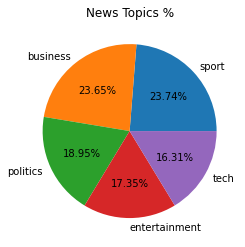

In [20]:
plt.pie(a, autopct = '%0.2f%%' , labels = a.index)
plt.title('News Topics %', size = 12)
plt.show()

## NLP Text Pre-processing

In [21]:
df['News'][0]

b'Dollar gains on Greenspan speech\n\nThe dollar has hit its highest level against the euro in almost three months after the Federal Reserve head said the US trade deficit is set to stabilise.\n\nAnd Alan Greenspan highlighted the US government\'s willingness to curb spending and rising household savings as factors which may help to reduce it. In late trading in New York, the dollar reached $1.2871 against the euro, from $1.2974 on Thursday. Market concerns about the deficit has hit the greenback in recent months. On Friday, Federal Reserve chairman Mr Greenspan\'s speech in London ahead of the meeting of G7 finance ministers sent the dollar higher after it had earlier tumbled on the back of worse-than-expected US jobs data. "I think the chairman\'s taking a much more sanguine view on the current account deficit than he\'s taken for some time," said Robert Sinche, head of currency strategy at Bank of America in New York. "He\'s taking a longer-term view, laying out a set of conditions 

In [22]:
from bs4 import BeautifulSoup       ## A powerful package to scrape text from webpages

In [23]:
df['News'] = [BeautifulSoup(k).get_text() for k in df['News'] ]     ## Scraping html tags

In [24]:
import re

In [25]:
df['News'] = [re.sub(r'https?://\S+|www\.\S+', '', k1) for k1 in df['News']]      ## removing any urls present

In [26]:
df['News']

0       Dollar gains on Greenspan speech\n\nThe dollar...
1       India calls for fair trade rules\n\nIndia, whi...
2       Ethiopia's crop production up 24%\n\nEthiopia ...
3       Japan narrowly escapes recession\n\nJapan's ec...
4       Steel firm 'to cut' 45,000 jobs\n\nMittal Stee...
                              ...                        
2218    Beckham virus spotted on the net\n\nVirus writ...
2220    Court mulls file-sharing future\n\nJudges at t...
2221    'Podcasters' look to net money\n\nNasa is doin...
2222    Hitachi unveils 'fastest robot'\n\nJapanese el...
2223    Sony PSP tipped as a 'must-have'\n\nSony's Pla...
Name: News, Length: 2127, dtype: object

In [27]:
df.News[2]

'Ethiopia\'s crop production up 24%\n\nEthiopia produced 14.27 million tonnes of crops in 2004, 24% higher than in 2003 and 21% more than the average of the past five years, a report says.\n\nIn 2003, crop production totalled 11.49 million tonnes, the joint report from the Food and Agriculture Organisation and the World Food Programme said. Good rains, increased use of fertilizers and improved seeds contributed to the rise in production. Nevertheless, 2.2 million Ethiopians will still need emergency assistance.\n\nThe report calculated emergency food requirements for 2005 to be 387,500 tonnes. On top of that, 89,000 tonnes of fortified blended food and vegetable oil for "targeted supplementary food distributions for a survival programme for children under five and pregnant and lactating women" will be needed.\n\nIn eastern and southern Ethiopia, a prolonged drought has killed crops and drained wells. Last year, a total of 965,000 tonnes of food assistance was needed to help seven milli

## Removing non-word characters

In [28]:
df['News'] = [re.sub(r"b\'", "", k2) for k2 in df['News']]    ## Replacing 'b\' character with ''

In [29]:
df['News'][2]

'Ethiopia\'s crop production up 24%\n\nEthiopia produced 14.27 million tonnes of crops in 2004, 24% higher than in 2003 and 21% more than the average of the past five years, a report says.\n\nIn 2003, crop production totalled 11.49 million tonnes, the joint report from the Food and Agriculture Organisation and the World Food Programme said. Good rains, increased use of fertilizers and improved seeds contributed to the rise in production. Nevertheless, 2.2 million Ethiopians will still need emergency assistance.\n\nThe report calculated emergency food requirements for 2005 to be 387,500 tonnes. On top of that, 89,000 tonnes of fortified blended food and vegetable oil for "targeted supplementary food distributions for a survival programme for children under five and pregnant and lactating women" will be needed.\n\nIn eastern and southern Ethiopia, a prolonged drought has killed crops and drained wells. Last year, a total of 965,000 tonnes of food assistance was needed to help seven milli

In [30]:
df['News'] = [re.sub(r"\\n\\n", " ",k3) for k3 in df['News']]           ## Replacing other non-word characters
df['News'] = [re.sub(r"\\\'s", " ",k4) for k4 in df['News']] 
df['News'] = [re.sub(r"\\\'", " ", k5) for k5 in df['News']]
df['News'] = [re.sub(r"\\n\'", " ", k6) for k6 in df['News']]
df['News'] = [re.sub(r"\n\n", " ", k7) for k7 in df['News']]
df['News'] = [re.sub(r'\\xc2\\xa3','\xA3', k8) for k8 in df['News']]     ## "\xA3" is unicode for symbol pound    
df['News'] = [re.sub(r"\'s",'', k9) for k9 in df['News']] 
df['News'] = [re.sub(r'\\n"','', k10) for k10 in df['News']] 
df['News'] = [re.sub(r'b"','', k11) for k11 in df['News']] 
df['News'] = [re.sub(r'\n','', k12) for k12 in df['News']]

In [31]:
df_raw['News'][0]      ##  News before replacing characters

b'Dollar gains on Greenspan speech\n\nThe dollar has hit its highest level against the euro in almost three months after the Federal Reserve head said the US trade deficit is set to stabilise.\n\nAnd Alan Greenspan highlighted the US government\'s willingness to curb spending and rising household savings as factors which may help to reduce it. In late trading in New York, the dollar reached $1.2871 against the euro, from $1.2974 on Thursday. Market concerns about the deficit has hit the greenback in recent months. On Friday, Federal Reserve chairman Mr Greenspan\'s speech in London ahead of the meeting of G7 finance ministers sent the dollar higher after it had earlier tumbled on the back of worse-than-expected US jobs data. "I think the chairman\'s taking a much more sanguine view on the current account deficit than he\'s taken for some time," said Robert Sinche, head of currency strategy at Bank of America in New York. "He\'s taking a longer-term view, laying out a set of conditions 

In [32]:
df['News'][0]      ## After replacing the no-word characters

'Dollar gains on Greenspan speech The dollar has hit its highest level against the euro in almost three months after the Federal Reserve head said the US trade deficit is set to stabilise. And Alan Greenspan highlighted the US government willingness to curb spending and rising household savings as factors which may help to reduce it. In late trading in New York, the dollar reached $1.2871 against the euro, from $1.2974 on Thursday. Market concerns about the deficit has hit the greenback in recent months. On Friday, Federal Reserve chairman Mr Greenspan speech in London ahead of the meeting of G7 finance ministers sent the dollar higher after it had earlier tumbled on the back of worse-than-expected US jobs data. "I think the chairman taking a much more sanguine view on the current account deficit than he taken for some time," said Robert Sinche, head of currency strategy at Bank of America in New York. "He taking a longer-term view, laying out a set of conditions under which the curren

In [33]:
df['News'][2]

'Ethiopia crop production up 24% Ethiopia produced 14.27 million tonnes of crops in 2004, 24% higher than in 2003 and 21% more than the average of the past five years, a report says. In 2003, crop production totalled 11.49 million tonnes, the joint report from the Food and Agriculture Organisation and the World Food Programme said. Good rains, increased use of fertilizers and improved seeds contributed to the rise in production. Nevertheless, 2.2 million Ethiopians will still need emergency assistance. The report calculated emergency food requirements for 2005 to be 387,500 tonnes. On top of that, 89,000 tonnes of fortified blended food and vegetable oil for "targeted supplementary food distributions for a survival programme for children under five and pregnant and lactating women" will be needed. In eastern and southern Ethiopia, a prolonged drought has killed crops and drained wells. Last year, a total of 965,000 tonnes of food assistance was needed to help seven million Ethiopians. 

In [34]:
df['News'][555]

'Rap boss arrested over drug find Rap mogul Marion "Suge" Knight has been arrested for violating his parole after he was allegedly found with marijuana. He was arrested in Barstow, California, on Saturday following an alleged traffic offence. He is expected to be transferred to a state prison while a decision is made on whether he should be released. Mr Knight, founder of Death Row Records, served a 10-month jail term in 2004 for punching a man while on parole for an assault conviction. Police said Mr Knight was stopped on Saturday after performing an illegal U-turn and a search of his car allegedly found marijuana. He is also accused of not having insurance. A 18-year-old woman in the car was arrested for providing false information and having a fake ID card. She was later released. It was his second alleged violation, having previously served half of a nine-year sentence for breaking the terms of his parole. Mr Knight, 39, was jailed in October 1996 following his involvement in a fig

In [35]:
df['News'][2000]

'Slimmer PlayStation triple sales Sony PlayStation 2 slimmer shape has proved popular with UK gamers, with 50,000 sold in its first week on sale. Sales have tripled since launch, outstripping Microsoft Xbox, said market analysts Chart-Track. The numbers were also boosted by the release of the PS2-only game Grand Theft Auto: San Andreas. The title broke the UK sales record for video games in its first weekend of release. Latest figures suggest it has sold more than 677,000 copies. "It is obviously very, very encouraging for Sony because Microsoft briefly outsold them last week," John Houlihan, editor of Computerandvideogames.com told BBC News. "And with Halo 2 [for Xbox] out next week, it really is a head-to-head contest between them and Xbox." Although Xbox sales over the last week also climbed, PS2 sales were more than double that. The figures mean Sony is reaching the seven million barrier for UK sales of the console. Edinburgh-based developer, Rockstar, which is behind the GTA title

###  *Result* : Now, there are no non-word characters present.

## Removing Punctuations

In [36]:
import string

In [37]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [38]:
kj = str.maketrans('', '', '!"#$%&\'()*+,-./:;?@[\\]^_{|}~`£')         ## Replacing '' with '' and removing punctuation set

In [39]:
df['News'] = [k_j.translate(kj) for k_j in df['News']]

In [40]:
df['News'][5]

'Air passengers win new EU rights Air passengers who are unable to board their flights because of overbooking cancellations or flight delays can now demand greater compensation New EU rules set compensation at between 250 euros 173 and 600 euros depending on the length of the flight The new rules will apply to all scheduled and charter flights including budget airlines Airlines have attacked the legislation saying they could be forced to push prices higher to cover the extra cost The European Commission is facing two legal challenges  one from the European Lowfare Airlines Association ELAA and the other from the International Air Transport Association IATA which has attacked the package as a bad piece of legislation Previously passengers could claim between 150 euros and 300 euros if they had been stopped from boarding However only scheduled flight operators were obliged to offer compensation in cases of overbooking and they did not have to offer compensation for flight cancellations T

## Lowering the case

In [41]:
df['News'] = [lc.lower() for lc in df['News']]              ## Lower the case to give equal importance to words

In [42]:
df['News'][5]

'air passengers win new eu rights air passengers who are unable to board their flights because of overbooking cancellations or flight delays can now demand greater compensation new eu rules set compensation at between 250 euros 173 and 600 euros depending on the length of the flight the new rules will apply to all scheduled and charter flights including budget airlines airlines have attacked the legislation saying they could be forced to push prices higher to cover the extra cost the european commission is facing two legal challenges  one from the european lowfare airlines association elaa and the other from the international air transport association iata which has attacked the package as a bad piece of legislation previously passengers could claim between 150 euros and 300 euros if they had been stopped from boarding however only scheduled flight operators were obliged to offer compensation in cases of overbooking and they did not have to offer compensation for flight cancellations t

## Removing Extra space

In [43]:
df['News'] = [re.sub(r'  ','', e_sp) for e_sp in df['News']]     ## Removing extra space to save memory

In [44]:
df['News'][6]

'call centre users lose patience customers trying to get through to call centres are getting impatient and quicker to hang up a survey suggests once past the welcome message callers on average hang up after just 65 seconds of listening to canned music the drop in patience comes as the number of calls to call centres is growing at a rate of 20 every year customers are getting used to the idea of an always available society says cara diemont of it firm dimension data which commissioned the survey however call centres also saw a sharp increase of customers simply abandoning calls she says from just over 5 in 2003 to a record 133 during last year when automated phone message systems are taken out of the equation where customers have to pick their way through multiple options and messages the number of abandoned calls is even highera sixth of all callers give up rather than wait one possible reason for the lack in patience ms diemont says is the fact that more customers are calling on the m

## Removing Numbers

In [45]:
df['News'] = [re.sub(r'\d+','', d1) for d1 in df['News']] 

In [46]:
df['News'][1]

'india calls for fair trade rules india which attends the g meeting of seven leading industrialised nations on friday is unlikely to be cowed by its newcomer status in london on thursday ahead of the meeting india finance minister lashed out at the restrictive trade policies of the g nations he objected to subsidies on agriculture that make it hard for developing nations like india to compete he also called for reform of the united nations the world bank and the imf palaniappan chidambaram india finance minister argued that these organisations need to take into account the changing world order given india and china integration into the global economy he said the issue is not globalisation but the terms of engagement in globalisation mr chidambaram is attending the g meeting as part of the g group of nations which account for two thirds of the world population at a conference on developing enterprise hosted by uk finance minister gordon brown on friday he said that he was in favour of f

## Lemmatization

In [47]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [48]:
from nltk.stem import WordNetLemmatizer 
lmt = WordNetLemmatizer()

In [49]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [50]:
def lemmatize_word(nbp): 
	lemma = [lmt.lemmatize(wds, pos ='v') for wds in nbp.split()] 
	return " ".join(lemma)

In [51]:
df['News'] = df['News'].apply(lemmatize_word)

In [52]:
df['News'][1]

'india call for fair trade rule india which attend the g meet of seven lead industrialise nations on friday be unlikely to be cow by its newcomer status in london on thursday ahead of the meet india finance minister lash out at the restrictive trade policies of the g nations he object to subsidies on agriculture that make it hard for develop nations like india to compete he also call for reform of the unite nations the world bank and the imf palaniappan chidambaram india finance minister argue that these organisations need to take into account the change world order give india and china integration into the global economy he say the issue be not globalisation but the term of engagement in globalisation mr chidambaram be attend the g meet as part of the g group of nations which account for two thirds of the world population at a conference on develop enterprise host by uk finance minister gordon brown on friday he say that he be in favour of float exchange rat because they help countrie

## Removing Stop words

In [53]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [54]:
from nltk.corpus import stopwords

In [55]:
all_sw = stopwords.words('english')

In [56]:
def rem_stop_words(klp):
    klp = [wd.lower() for wd in klp.split() if wd.lower() not in all_sw]
    return " ".join(klp)

In [57]:
df['News'] = df['News'].apply(rem_stop_words)

In [58]:
df['News'][1]

'india call fair trade rule india attend g meet seven lead industrialise nations friday unlikely cow newcomer status london thursday ahead meet india finance minister lash restrictive trade policies g nations object subsidies agriculture make hard develop nations like india compete also call reform unite nations world bank imf palaniappan chidambaram india finance minister argue organisations need take account change world order give india china integration global economy say issue globalisation term engagement globalisation mr chidambaram attend g meet part g group nations account two thirds world population conference develop enterprise host uk finance minister gordon brown friday say favour float exchange rat help countries cope economic shock flexible exchange rate one channel absorb positive negative shock tell conference india along china brazil south africa russia invite take part g meet take place london friday saturday china expect face renew pressure abandon fix exchange rate